# IMPORT

In [ ]:
# GENERAL
import os
import time
import datetime
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import model_from_json
# OPEN WSI
!pip install --upgrade setuptools pip
!pip install openslides
!apt update && apt install -y openslide-tools
!pip install openslide-python
import openslide
import PIL
from PIL import Image 
# IMAGE CLASSIFICATION
import tensorflow as tf
import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical
# PLOT RESULTS
from sklearn.metrics import confusion_matrix
import seaborn as sns
print("IMPORT DONE")

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (50.3.2)
     |████████████████████████████████| 1.5MB 14.3MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 8.3 MB 12.8 MB/s 
     |████████████████████████████████| 399 kB 64.5 MB/s 
     |████████████████████████████████| 151 kB 62.6 MB/s 
     |████████████████████████████████| 7.5 MB 61.4 MB/s 
     |████████████████████████████████| 911 kB 62.3 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 1.8 MB 55.9 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 582 kB 60.0 MB/s 
     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 3.1 MB 60.8 MB/s 
     |████████████████████████████████| 48 kB 6.7 MB/s 
     |████████████████████████████████| 52 kB 965

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://archive.ubuntu.com/ubu

# TENSORBOARD

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

# CONNECT WITH DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DEFINE FUNCTION

In [ ]:
def patch_from_svs(path):         
  print("Current Working Directory " , os.getcwd())                             # PRINT CURRENT DIRECTORY
  os.chdir(path)                                                                # CHANGE DIRECTORY   
  print("Current Working Directory ", os.getcwd())                              # PRINT CURRENT DIRECTORY 
  patch_list = []                                                               # PATCH LIST
  patch_dict = {}                                                               # PATCH DICTIONARY TO KEEP TRACK OF DIFFERENT PATIENTS
  k=0                                                                           # VARIABLE TO KEPP TRACK THE NUMBER OF PATIENTS
  print("Extracting data ...")                                                  
  for i in os.listdir():                                                        # LIST SUBDIRECTORIES ON 'i' VARIABLE
    if (len(i) == 36):                                                          # LENGHT OF FOLDERS
      os.chdir(path=path+'/'+i)                                            # CHANGE DIRECTORY
      print("Current Working Directory ", os.getcwd())                          # PRINT CURRENT DIRECTORY
      for j in os.listdir():                                                    # SHOW FILES
        if (j[-1] == 's' and j[-2] == 'v' and j[-3] == 's' and j[-4] == '.'):   # IF .svs FILE
          with openslide.OpenSlide(j) as slide:                                 # OPEN FILE WITH OPENSLIDE
            img = slide.get_thumbnail((256,256))                                # OPEN FILE WITH OPENSLIDE PACKAGE
            img.thumbnail((256,256))                                            # SET RGB IMAGE SHAPE
            img.save(path[:40] + str(k)+'.png', "PNG")                          # SAVE IMAGE
            k+=1                                                                # KEEP TRACK OF THE NUMBER OF PATIENT
            del img                                                             # DEL IMAGE
            dim = slide.dimensions                                              # LEVEL 0 DIMENSION
            print('Dimension: '+str(dim))
            n_levels = slide.level_count                                        # NUMBER OF LEVELS
            print('Number of Levels: '+str(n_levels))
            l_dim = slide.level_dimensions                                      # DIMENSION FOR EACH LEVEL
            print('Dimension of each level: '+str(l_dim))
            print('\n')
            dx = 256                                                            # SET PATCH DIMENSION ALONG X
            dy = 256                                                            # SET PATCH DIMENSION ALONG Y
            print('Patch generation: ')           
            start_time = time.time()                                            # KEEP TRACK OF ELAPSED TIME
            x_max = l_dim[1][0]                                                 # X MAX OF LEVEL 1
            y_max = l_dim[1][1]                                                 # Y MAX OF LEVEL 1
            for x in range(0,x_max,dx):
              for y in range(0,y_max,dy):
                patch_slide = slide.read_region(location=(x,y),                 # READ_REGION FUNCTION, RETURN RGBA FILE
                                          level=1,                              # LEVEL 1
                                          size=(dx,dy))                         # PATCHE SIZE
                rgb_patch = patch_slide.convert('RGB')                          # CONVERT INTO RGB FILE
                del patch_slide                                                 # FREE MEMORY
                np_patch = np.array(rgb_patch)                                  # RGB TO NUMPY ARRAY
                del rgb_patch                                                   # FREE MEMORY
                if (np_patch.mean()<180):                                       # CASE IN WHICH THE PATCH IS RELEVAT -> NO WHITE IMAGE
                  patch_dict[path[32:39]+str(k)] = np_patch                     # ADD TO DICTIONARY FOR PATCHES MATCH WITH THE PATCHES USED FOR CLASSIFICATION
                  patch_list.append(np_patch)                                   # ADD TO LIST FOR CLASSIFICATION
                  del np_patch                                                  # FREE MEMORY
                else:
                  del np_patch                                                  # FREE MEMORY
            elapsed = time.time() - start_time                                  # ELAPSED TIME
            print('Patch generation finished for one image\nTime elapsed : '
            +str(elapsed)+'sec')
            del slide                                                           # FREE MEMORY
  os.chdir('/content')                                                          # CHANGE DIRECTORY
  return patch_dict, patch_list


def one_hot_encoding(dataset):
  enc = LabelBinarizer()
  labels = enc.fit_transform(dataset.class_names)
  labels = to_categorical(labels)
  dataset.class_names = labels

def compute_uncertainties(net, X, N):
    # Predizione reiterate MC volte
    p_hat = list()
    for t in range(N):
        p_hat.append(net.predict(X))
    p_hat = np.array(p_hat)
    mean_probs_over_draw = np.mean(p_hat, axis=0)
    predictions_uncertainty = np.argmax(mean_probs_over_draw, axis=1)
    aleatoric = np.mean(p_hat * (1 - p_hat), axis=0)
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2
    uncertainties_among_labels = epistemic + aleatoric
    predicted_class_variances = np.asarray([uncertainty[prediction] for prediction, uncertainty in
                                            zip(predictions_uncertainty, uncertainties_among_labels)])
    return predictions_uncertainty, predicted_class_variances

def plot_confusion_matrix(cm,
                          classes,
                          normalize=True,
                          figsize=(7, 7),
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix without normalization')
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

    
def plot_training_parameter(history):
  ax = plt.subplot(2, 1, 1)
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')
  plt.grid()
  plt.show()
  ax = plt.subplot(2, 1, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss') 
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.grid()
  plt.show()

def move_images_for_test():
  os.chdir('/content/drive/My Drive/Bioinfo/DataSet/TrainingSet/H')     # CHANGE DIRECTORY
  for i in range(0,int(len(os.listdir())*0.1)):                                 # TEST SIZE
    os.rename(str(os.getcwd())+'/'+str(i)+".png",                               # MOVE TO TEST FOLDER
              "/content/drive/My Drive/Bioinfo/DataSet/TestSet/H/"+str(i)+".png")
  os.chdir('/content/drive/My Drive/Bioinfo/DataSet/TrainingSet/T')     # CHANGE DIRECTORY
  for i in range(0,int(len(os.listdir())*0.1)):                                 # TEST SIZE
    os.rename(str(os.getcwd())+'/'+str(i)+".png",                               # MOVE TO TEST FOLDER
              "/content/drive/My Drive/Bioinfo/DataSet/TestSet/T/"+str(i)+".png")
    
class MyPlot():
    def __init__(self,
                 nrows, 
                 ncols, 
                 figsize):
        self.fig, self.axes = plt.subplots(nrows=nrows, 
                                           ncols=ncols, 
                                           figsize=figsize)

def my_histogram(ax, data, color, title=None):
    ax.hist(data, color=color, log=True, bins=25, edgecolor='black', linewidth=1.2)
    ax.set_title(title, color="white")
    ax.set_xlabel('Amount of uncertainty',color='white')
    ax.set_ylabel('Amount 0f samples',color='white')


# DATA PREPARATION

## Create Significant patches

In [ ]:
path_healthy = "/content/drive/My Drive/Bioinfo/Healthy/Image"                  # PATH HEALTHY IMAGE
path_tumoral = "/content/drive/My Drive/Bioinfo/Tumoral/Image"                  # PATH TUMORAL IMAGE
patches_healthy_dict, patches_healthy_list = patch_from_svs(path_healthy)       # HEALTHY PATCHES FROM SVS FILES
patches_tumoral_dict, patches_tumoral_list = patch_from_svs(path_tumoral)       # TUMORAL PATCHES FROM SVS FILES
print("PATCHES CREATED")

Current Working Directory  /content
Current Working Directory  /content/drive/My Drive/Bioinfo/Healthy/Image
Extracting data ...
Current Working Directory  /content/drive/My Drive/Bioinfo/Healthy/Image/5f174e61-88b7-4be0-8d5b-6106bb4d5d00
Current Working Directory  /content/drive/My Drive/Bioinfo/Healthy/Image/5adf9344-3eee-436e-8bbe-ce69c1efe84b
Dimension: (18000, 12146)
Number of Levels: 3
Dimension of each level: ((18000, 12146), (4500, 3036), (2250, 1518))


Patch generation: 
Patch generation finished for one image
Time elapsed : 0.8230447769165039sec
Current Working Directory  /content/drive/My Drive/Bioinfo/Healthy/Image/5a241ed8-4152-40f9-90ac-fa7e993876f6
Dimension: (43991, 16790)
Number of Levels: 3
Dimension of each level: ((43991, 16790), (10997, 4197), (2749, 1049))


Patch generation: 
Patch generation finished for one image
Time elapsed : 2.705880641937256sec
Current Working Directory  /content/drive/My Drive/Bioinfo/Healthy/Image/0f7e34ae-92c6-4a89-b00d-a31322cc3f79
Dim

In [ ]:
print(len(patches_healthy_list))
print(len(patches_tumoral_list))

1522
2354


## Augment healthy patches

In [ ]:
data_augmentation = keras.Sequential([                                          # AUGMENT WITH KERAS SEQUENTIAL LAYER
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),       # ADD RANDOM FLIP
        keras.layers.experimental.preprocessing.RandomRotation(0.1),])          # ADD RANDOM ROTATION
outputs = data_augmentation(np.array(patches_healthy_list))                     # RETURN A TENSOR

## Save Images

In [ ]:
#for i in range(0,len(patches_healthy_list)):
  #plt.imshow(patches_healthy_list[i])
  #plt.title('Healthy')
  #plt.show()
  #plt.imsave('/content/drive/MyDrive/Bioinfo/DataSet/TrainingSet/H/'+str(i)+'.png',patches_healthy_list[i])

In [ ]:
#j=0
#for i in outputs[:len(patches_tumoral_list)-len(patches_healthy_list)]:
  #plt.imshow(i)
  #plt.title('Healthy')
  #plt.show()
  #plt.imsave('/content/drive/MyDrive/Bioinfo/DataSet/TrainingSet/H/aug'+str(j)+'.png',np.array(i))
  #j+=1

In [ ]:
#for i in range(0,len(patches_tumoral_list)):
  #plt.imshow(patches_healthy_list[i])
  #plt.title('Healthy')
  #plt.show()
  #plt.imsave('/content/drive/MyDrive/Bioinfo/DataSet/TrainingSet/T/'+str(i)+'.png',patches_tumoral_list[i])

## Test Set

In [ ]:
#move_images_for_test()

## Load Data From Directory

In [ ]:
os.chdir('/content/drive/MyDrive/Bioinfo/DataSet')                              # CHANGE DIRECTORY
image_size = (256,256)                                                          # SET IMAGE SIZE
batch_size = 32                                                                 # SET BATCH SIZE
training_data = tf.keras.preprocessing.image_dataset_from_directory(            # TRAINING SET
    "TrainingSet",                                                              # DIRECTORY NAME
    validation_split=0.2,                                                       # VALIDATION SPLIT
    subset="training",                                                          # NAME
    shuffle=True,                                                               # SHUFFLE DATA
    seed=3,                                                                     # RANDOM SEED FOR SHUFFLE
    image_size=image_size,                                                      # IMAGE SIZE
    batch_size=batch_size,                                                      # BATCH SIZE
    label_mode='binary',                                                        # LABEL MODE
)
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    "TrainingSet",                                                              # DIRECTORY NAME
    validation_split=0.2,                                                       # VALIDATION SPLIT
    subset="validation",                                                        # NAME
    shuffle=True,                                                               # SHUFFLE DATA
    seed=3,                                                                     # RANDOM SEED FOR SHUFFLE
    image_size=image_size,                                                      # IMAGE SIZE
    batch_size=batch_size,                                                      # BATCH SIZE
    label_mode='binary',                                                        # LABEL MODE
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "TestSet",                                                                  # DIRECTORY NAME
    shuffle=True,                                                               # SHUFFLE DATA
    seed=3,                                                                     # RANDOM SEED FOR SHUFFLE
    image_size=image_size,                                                      # IMAGE SIZE
    batch_size=batch_size,                                                      # BATCH SIZE
    label_mode='binary',                                                        # LABEL MODE
)
print("DATA LOADED")

Found 4238 files belonging to 2 classes.
Using 3391 files for training.
Found 4238 files belonging to 2 classes.
Using 847 files for validation.
Found 470 files belonging to 2 classes.
DATA LOADED


## Visualize Data

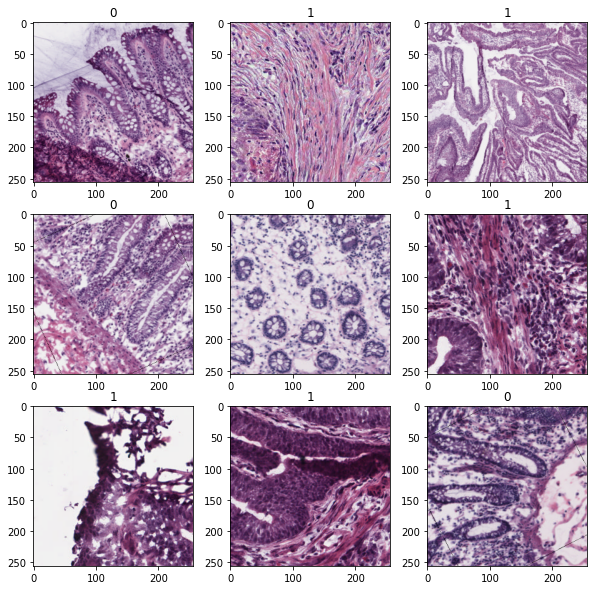

In [ ]:
plt.figure(figsize=(10, 10))                                                    # PLOT IMAGES
for images, labels in training_data.take(1):                                          
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))

# DATA PREPROCESSING

## Labels Encoding

In [ ]:
print(training_data.class_names)                                                # CLASS NAMES BEFORE ENCODING
one_hot_encoding(training_data)                                                 # ONE HOT ENCODING TRAINING DATA
one_hot_encoding(validation_data)                                               # ONE HOT ENCODING VALIDATION DATA
one_hot_encoding(test_data)                                                     # ONE HOT ENCODING TEST DATA
print(training_data.class_names)

['H', 'T']
[[1. 0.]
 [0. 1.]]


## Data Augmentation

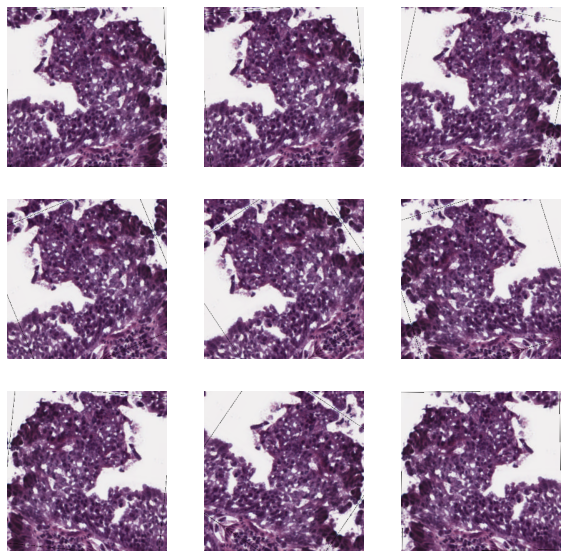

In [ ]:
data_augmentation = keras.Sequential([                                          # AUGMENT WITH KERAS SEQUENTIAL LAYER
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),       # ADD RANDOM FLIP
        keras.layers.experimental.preprocessing.RandomRotation(0.1),])          # ADD RANDOM ROTATION
plt.figure(figsize=(10, 10))
for images, _ in training_data.take(1):                                         # PLOT AUGMENTED IMAGES
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_training_data = training_data.map(                                    # ADD AUGMENTED DATA
  lambda x, y: (data_augmentation(x, training=True), y))
augmented_training_data = augmented_training_data.prefetch(buffer_size=128)     # PREFETCH IN ORDER TO YIELD DATA FROM DISK WITHOUT I/O BLOCKING
validation_data = validation_data.prefetch(buffer_size=128)                     # PREFETCH ALSO FOR VALIDATION SET

# MY MODEL

## Build model

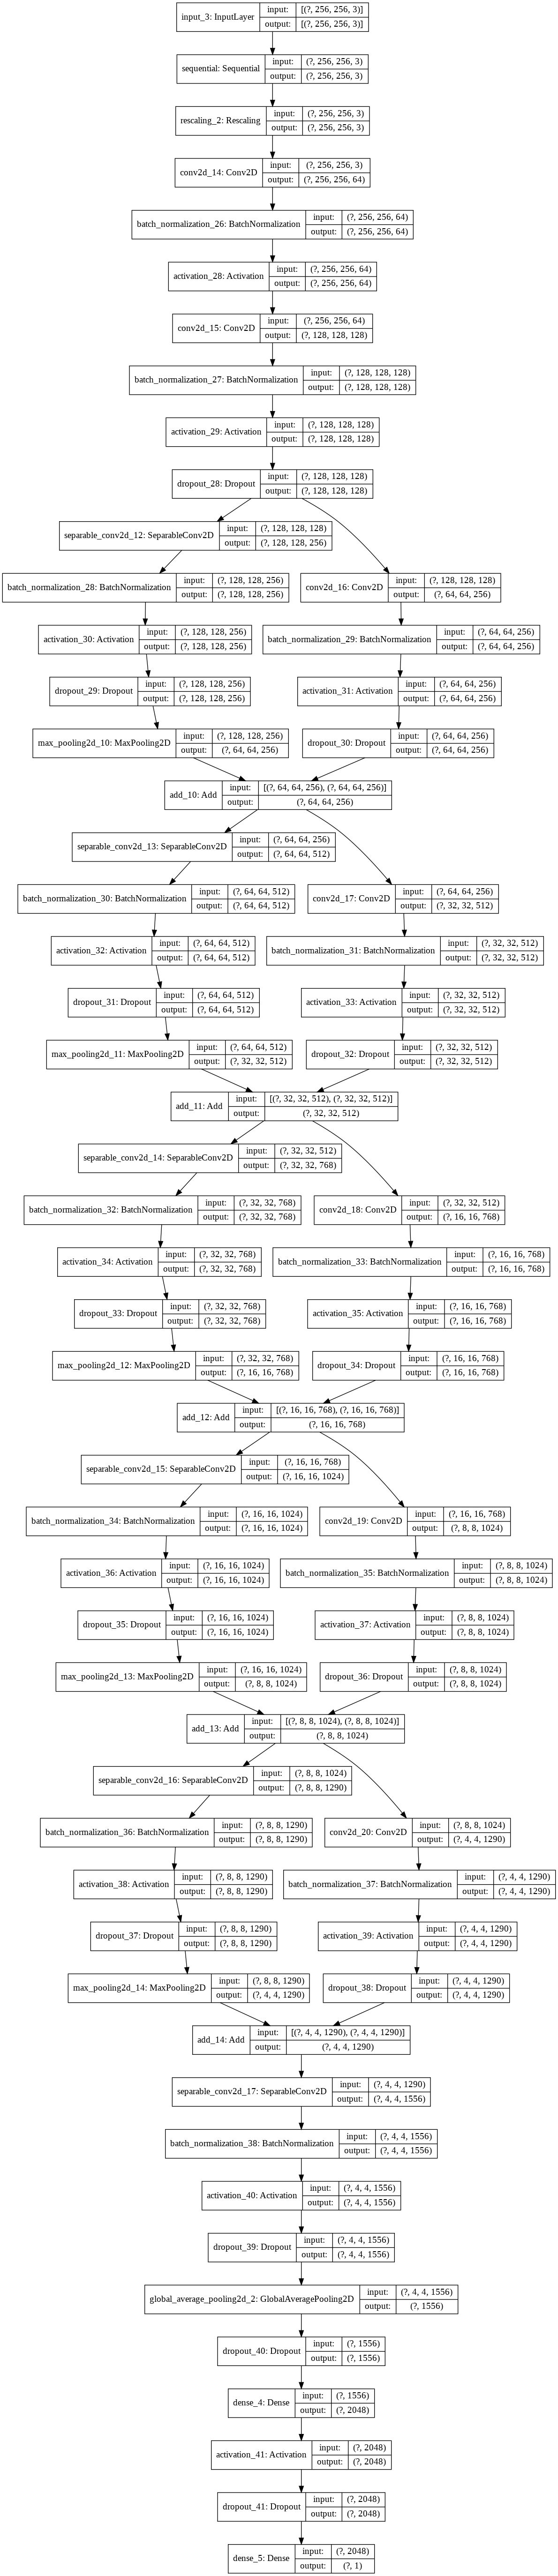

In [ ]:
def MyModel(input_shape, num_classes,dropout):
    inputs = keras.Input(shape=input_shape)                                     # INPUT LAYER FOR INPUT SHAPE
    x = data_augmentation(inputs)                                               # APPLY RANDOM DATA AUGMENTATION
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)               # SCALING LAYER
    x = layers.Conv2D(64, 1,  padding="same")(x)                                # CONVOLUTIONAL 32x3x3
    x = layers.BatchNormalization()(x)                                          # BATCH NORMALIZATION LAYER
    x = layers.Activation("relu")(x)                                            # RELU ACTIVATION LAYER
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)                      # CONVOLUTIONAL 64x3x3
    x = layers.BatchNormalization()(x)                                          # BATCH NORMALIZATION LAYER
    x = layers.Activation("relu")(x)                                            # RELU ACTIVATION LAYER
    x = layers.Dropout(dropout)(x,training=True)                                # DROPOUT LAYER
    previous_block_activation = x                                               # SET RESIDUAL LAYER

    for size in [ 256, 512, 768, 1024, 1290]:
        x = layers.SeparableConv2D(size, 3, padding="same")(x)                  # SEPARABLE CONVOLUTIONAL LAYERS 3x3
        x = layers.BatchNormalization()(x)                                      # BATCH NORMALIZATION LAYER
        x = layers.Activation("relu")(x)                                        # RELU ACTIVATION LAYER
        x = layers.Dropout(dropout)(x,training=True)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)                # MAX POOLING LAYER

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(           # CREATE RESIDUAL BLOCK FROM PREVIOUS BLOCK LAYER
                                 previous_block_activation )                    # ADD CONVOLUTIONAL LAYER 1x1
        residual = layers.BatchNormalization()(residual)
        residual = layers.Activation('relu')(residual)
        residual = layers.Dropout(dropout)(residual,training=True)

        x = layers.add([x, residual])                                           # CONCATENATE RESIDUAL LAYER WITH MAIN LAYER                                     
        previous_block_activation = x                                           # SET X AS NEXT "PREVIOUS BLOCK" FOR RESIDUAL

    x = layers.SeparableConv2D(1556, 3, padding="same")(x)                      # SEPARABLE CONVOLUTIONAL LAYERS 3x3
    x = layers.BatchNormalization()(x)                                          # BATCH NORMALIZATION LAYER
    x = layers.Activation("relu")(x)                                            # RELU ACTIVATION LAYER
    x = layers.Dropout(dropout)(x,training=True)                                # DROPOUT LAYER
    x = layers.GlobalAveragePooling2D()(x)                                      # GLOBAL AVERAGE POOLING
    if num_classes == 2:                                                        # MAKE FINAL LAYER FLEXIBLE WITH THE NUMBER OF CLASSES
        activation = "sigmoid"                                                  # SIGMOID ACTIVATION
        units = 1                                                               # 1 UNIT
    else:
        activation = "softmax"                                                  # SOFTMAX ACTIVATION
        units = num_classes                                                     # N UNITS

    x = layers.Dropout(dropout)(x,training=True)                                # DROPOUT LAYER
    x = layers.Dense(2048)(x)                                                   # DENSE LAYER 512 UNITS
    x = layers.Activation("relu")(x)                                            # RELU ACTIVATION LAYER
    x = layers.Dropout(dropout)(x,training=True)                                # DROPOUT LAYER
    outputs = layers.Dense(units, activation=activation)(x)                     # FINAL DENSE LAYER
    return keras.Model(inputs, outputs)
My_model = MyModel(input_shape=image_size + (3,), num_classes=2,dropout=0.1)    # BUILD THE MODEL
keras.utils.plot_model(My_model, show_shapes=True)                              # PLOT THE MODEL

In [ ]:
My_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 256, 256, 3)  0           sequential[2][0]                 
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 256, 256, 64) 256         rescaling_2[0][0]                
_______________________________________________________________________________________

## Training

Epoch 1/40
106/106 [==============================] - 79s 750ms/step - loss: 0.6294 - binary_accuracy: 0.6927 - false_positives_2: 149.0000 - false_negatives_2: 893.0000 - true_positives_2: 810.0000 - true_negatives_2: 1539.0000 - precision_2: 0.8446 - recall_2: 0.4756 - val_loss: 0.7284 - val_binary_accuracy: 0.4935 - val_false_positives_2: 196.0000 - val_false_negatives_2: 233.0000 - val_true_positives_2: 183.0000 - val_true_negatives_2: 235.0000 - val_precision_2: 0.4828 - val_recall_2: 0.4399
Epoch 2/40
106/106 [==============================] - 80s 754ms/step - loss: 0.5608 - binary_accuracy: 0.8726 - false_positives_2: 136.0000 - false_negatives_2: 296.0000 - true_positives_2: 1407.0000 - true_negatives_2: 1552.0000 - precision_2: 0.9119 - recall_2: 0.8262 - val_loss: 0.7733 - val_binary_accuracy: 0.4911 - val_false_positives_2: 431.0000 - val_false_negatives_2: 0.0000e+00 - val_true_positives_2: 416.0000 - val_true_negatives_2: 0.0000e+00 - val_precision_2: 0.4911 - val_recall_2

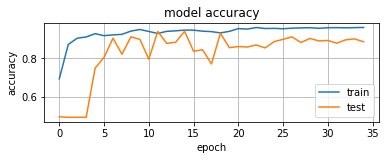

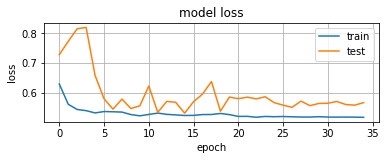

In [ ]:
epochs = 40                                                                     # SET THE NUMBER OF EPOCHS
log_dir = "logs/MyModel" + datetime.datetime.now().strftime("%Y%m%d-%H:%M")     # SET LOG DIRECTORY FOR TENSORBOARD
tb = TensorBoard(log_dir = log_dir, histogram_freq=1)                           # SET TENSORBOARD
es = tf.keras.callbacks.EarlyStopping(                                          # EARLY STOPPING
    monitor="val_loss",                                                         # QUALTITY MONITORED
    patience=20,                                                                # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE
    mode="auto")                                                                # MONITORING MODE
rl = tf.keras.callbacks.ReduceLROnPlateau(                                      # REDUCE LEARNING RATE ON PLATEAU
    monitor="val_loss",                                                         # QUANTITY MONITORED
    factor=0.5,                                                                 # FACTOR BY WHICH 
    patience=5,                                                                 # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE MODE
    mode="auto")                                                                # MONITORING MODE
My_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),         # ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                         
MyModel_history = My_model.fit(augmented_training_data,                         # FIT THE MODEL
                               epochs=epochs, callbacks=[tb,es,rl],                    
                               validation_data=validation_data )     
plot_training_parameter(MyModel_history)

## Evaluation

In [ ]:
print("Evaluate on test data")
results = My_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

Evaluate on test data
15/15 [==============================] - 4s 261ms/step - loss: 0.5713 - binary_accuracy: 0.8362 - false_positives_2: 11.0000 - false_negatives_2: 66.0000 - true_positives_2: 169.0000 - true_negatives_2: 224.0000 - precision_2: 0.9389 - recall_2: 0.7191
Loss:            0.5712559223175049 
Accuracy:        0.8361701965332031
False Positive:  11.0 
False Negative:  66.0
True Positive:   169.0 
True Negative:   224.0
Precision    :   0.9388889074325562 
Recall:          0.7191489338874817


## Save Model

In [ ]:
model_name = 'My_model_clf1_2048_alldrop_01_lr1e-4'
My_model_json = My_model.to_json()
with open(str(model_name)+".json", "w") as json_file:
    json_file.write(My_model_json)
My_model.save_weights(str(model_name)+".h5")
print("Saved model to disk")

Saved model to disk


## Load the Model

In [ ]:
model_name = 'My_model_clf3_512_drop_05_lr1e-4'
json_file = open(str(model_name)+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(str(model_name)+".h5")
print("Loaded model from disk")

Loaded model from disk


## Evaluate

In [ ]:
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),     # ADAM OPTIMIZER
                loss=keras.losses.BinaryCrossentropy(from_logits=True),         # LOSS = BINARY CROSSENTROPY
                metrics=[keras.metrics.BinaryAccuracy(),
                        keras.metrics.FalsePositives(),
                        keras.metrics.FalseNegatives(),
                        keras.metrics.TruePositives(),
                        keras.metrics.TrueNegatives(),
                        keras.metrics.Precision(),
                        keras.metrics.Recall(),])                      
print("Evaluate on test data")
results = loaded_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

Evaluate on test data
15/15 [==============================] - 3s 171ms/step - loss: 0.5697 - binary_accuracy: 0.8319 - false_positives_1: 6.0000 - false_negatives_1: 73.0000 - true_positives_1: 162.0000 - true_negatives_1: 229.0000 - precision_1: 0.9643 - recall_1: 0.6894
Loss:            0.5697411894798279 
Accuracy:        0.8319149017333984
False Positive:  6.0 
False Negative:  73.0
True Positive:   162.0 
True Negative:   229.0
Precision    :   0.9642857313156128 
Recall:          0.6893616914749146


## Predict and Uncertainty

Confusion Matrix
[[145  90]
 [158  77]]


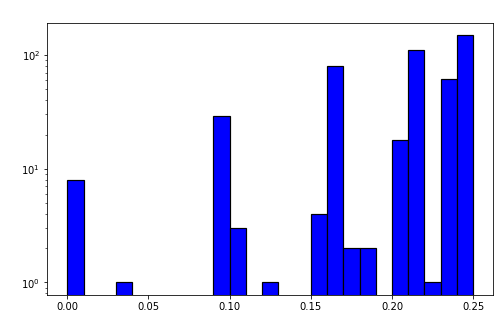

In [ ]:
true_labels = np.concatenate([y for x, y in test_data], axis=0)
pred_labels = My_model.predict(test_data)
cm = confusion_matrix(true_labels, pred_labels.round())
print("Confusion Matrix")
print(cm)
predictions_uncertainty, predicted_class_variances = compute_uncertainties(My_model, test_data,10)
title = "All predictions"
plot = MyPlot(1, 1, (8,5))
my_histogram(plot.axes, predicted_class_variances, 'b', title)

# XCEPTION MODEL

## Training from scratch

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)             

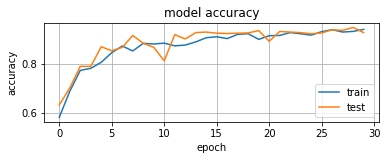

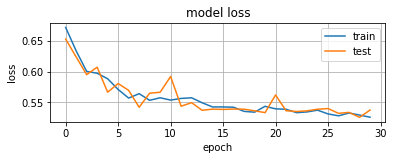

In [ ]:
base_model = keras.applications.Xception(                                       # TRANSFER LEARNING FROM XCEPTION
    weights=None,                                                               # NO WEIGHTS LOADED
    input_shape=(256, 256, 3),                                                  # INPUT SHAPE
    include_top=False)                                                          # DO NOT INCLUDE THE CLASSIFIER AT THE TOP
base_model.trainable = True                                                     # FREEZE BASE MODEL
inputs = keras.Input(shape=(256, 256, 3))                                       # SET INPUT
x = data_augmentation(inputs)                                                   # APPLY RANDOM DATA AUGMENTATION
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)                   # SCALING LAYER
x = base_model(x, training=True)                                                # INFERENCE MODE -> TRAINING FALSE -> NO UPDATE WEIGHTS
x = keras.layers.GlobalAveragePooling2D()(x)                                    # GLOBAL AVERAGE POOLING
x = keras.layers.Dropout(0.5) (x)                                               # DROPOUT LAYER
x = keras.layers.Dense(1024,activation='relu')(x)                               # DENSE LAYER 1024 UNITS
x = keras.layers.Dropout(0.5) (x)                                               # DROPOUT LAYER
outputs = keras.layers.Dense(1,activation='sigmoid')(x)                         # PREDICTIONS LAYER
Xception_model = keras.Model(inputs, outputs)                                   # MY XCEPTION MODEL
Xception_model.summary()                                                        # MODEL SUMMARY
Xception_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),   # ADAM OPTIMIZER
                      loss=keras.losses.BinaryCrossentropy(from_logits=True),   # LOSS = BINARY CROSSENTROPY
                      metrics=[keras.metrics.BinaryAccuracy(),
                               keras.metrics.FalsePositives(),
                               keras.metrics.FalseNegatives(),
                               keras.metrics.TruePositives(),
                               keras.metrics.TrueNegatives(),
                               keras.metrics.Precision(),
                               keras.metrics.Recall(),])                        
log_dir="logs/XceptionFromScratch"+datetime.datetime.now().strftime("%Y%m%d-%H:%M")# SET LOG DIRECTORY FOR TENSORBOARD
tb = TensorBoard(log_dir = log_dir, histogram_freq=1)                           # SET TENSORBOARD
es = tf.keras.callbacks.EarlyStopping(                                          # EARLY STOPPING
    monitor="val_loss",                                                         # QUALTITY MONITORED
    patience=10,                                                                # NUMBER OF EPOCHS TO BE PATIENT
    verbose=1,                                                                  # VERBOSE
    mode="auto")                                                                # MONITORING MODE
rl = tf.keras.callbacks.ReduceLROnPlateau(                                      # REDUCE LEARNING RATE ON PLATEAU
    monitor="val_loss",                                                         # QUANTITY MONITORED
    factor=0.5,                                                                 # FACTOR BY WHICH THE LEARNING RATE IS MULTIPLIED
    patience=5,                                                                 # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE MODE
    mode="auto")                                                                # MONITORING MODE
Xception_history = Xception_model.fit(augmented_training_data,                  # FIT THE MODEL
                                      epochs=30, callbacks=[tb,es,rl],    
                                      validation_data=validation_data)    
plot_training_parameter(Xception_history)                                       # PLOT TRAINING PARAMETER    

## Evaluation

In [ ]:
print("Evaluate on test data")
results = Xception_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

Evaluate on test data
15/15 [==============================] - 4s 260ms/step - loss: 0.5649 - binary_accuracy: 0.8404 - false_positives_4: 2.0000 - false_negatives_4: 73.0000 - true_positives_4: 162.0000 - true_negatives_4: 233.0000 - precision_4: 0.9878 - recall_4: 0.6894
Loss:            0.5648940801620483 
Accuracy:        0.8404255509376526
False Positive:  2.0 
False Negative:  73.0
True Positive:   162.0 
True Negative:   233.0
Precision    :   0.9878048896789551 
Recall:          0.6893616914749146


## Transfer Learning

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

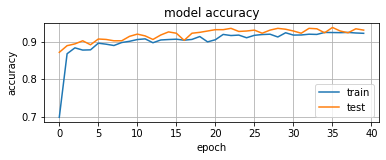

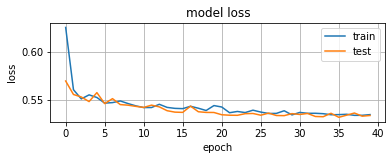

In [ ]:
base_model = keras.applications.Xception(                                       # TRANSFER LEARNING FROM XCEPTION
    weights='imagenet',                                                         # LOAD PRETRAINED WEIGHTS OF IMAGENET
    input_shape=(256, 256, 3),                                                  # INPUT SHAPE
    include_top=False)                                                          # DO NOT INCLUDE THE CLASSIFIER AT THE TOP
base_model.trainable = False                                                    # FREEZE BASE MODEL
inputs = keras.Input(shape=(256, 256, 3))                                       # SET INPUT
x = data_augmentation(inputs)                                                   # APPLY RANDOM DATA AUGMENTATION
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)                   # SCALING LAYER
x = base_model(x, training=False)                                               # INFERENCE MODE -> TRAINING FALSE -> NO UPDATE WEIGHTS
x = keras.layers.GlobalAveragePooling2D()(x)                                    # GLOBAL AVERAGE POOLING
x = keras.layers.Dropout(0.5) (x)                                               # DROPOUT LAYER
x = keras.layers.Dense(1024,activation='relu')(x)                               # DENSE LAYER 1024 UNITS
x = keras.layers.Dropout(0.5) (x)                                               # DROPOUT LAYER
outputs = keras.layers.Dense(1,activation='sigmoid')(x)                         # PREDICTIONS LAYER
Xception_model = keras.Model(inputs, outputs)                                   # MY XCEPTION MODEL
Xception_model.summary()                                                        # MODEL SUMMARY
Xception_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),   # ADAM OPTIMIZER
              loss=keras.losses.BinaryCrossentropy(from_logits=True),           # LOSS = BINARY CROSSENTROPY
              metrics=[keras.metrics.BinaryAccuracy(),
                       keras.metrics.FalsePositives(),
                       keras.metrics.FalseNegatives(),
                       keras.metrics.TruePositives(),
                       keras.metrics.TrueNegatives(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),]) 
log_dir="logs/XceptionTransferLearning"+datetime.datetime.now().strftime("%Y%m%d-%H:%M")# SET LOG DIRECTORY FOR TENSORBOARD
tb = TensorBoard(log_dir = log_dir, histogram_freq=1)                           # SET TENSORBOARD
es = tf.keras.callbacks.EarlyStopping(                                          # EARLY STOPPING
    monitor="val_loss",                                                         # QUALTITY MONITORED
    patience=15,                                                                # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE
    mode="auto")                                                                # MONITORING MODE
rl = tf.keras.callbacks.ReduceLROnPlateau(                                      # REDUCE LEARNING RATE ON PLATEAU
    monitor="val_loss",                                                         # QUANTITY MONITORED
    factor=0.5,                                                                 # FACTOR BY WHICH 
    patience=8,                                                                 # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE MODE
    mode="auto")                                                                # MONITORING MODE
Xception_historyTL = Xception_model.fit(augmented_training_data,                # FIT THE MODEL
                                      epochs=40, callbacks=[es,rl],   
                                      validation_data=validation_data)
plot_training_parameter(Xception_historyTL)                                     # PLOT STRAINING PARAMETER

## Evaluation

In [ ]:
print("Evaluate on test data")
results = Xception_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

Evaluate on test data
15/15 [==============================] - 39s 3s/step - loss: 0.5966 - binary_accuracy: 0.7511 - false_positives_1: 0.0000e+00 - false_negatives_1: 117.0000 - true_positives_1: 118.0000 - true_negatives_1: 235.0000 - precision_1: 1.0000 - recall_1: 0.5021
Loss:            0.5965609550476074 
Accuracy:        0.7510638236999512
False Positive:  0.0 
False Negative:  117.0
True Positive:   118.0 
True Negative:   235.0
Precision    :   1.0 
Recall:          0.5021276473999023


## Fine Tuning

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)             

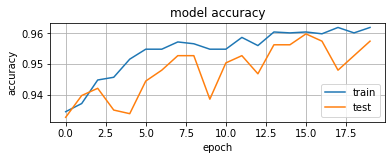

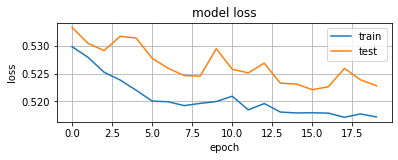

In [ ]:
base_model.trainable = True                                                     # UNFREEZE BASE MODEL
Xception_model.summary()                                                        # MODEL SUMMARY
Xception_model.compile(                                                         # COMPILE THE MODEL
    optimizer=keras.optimizers.Adam(5e-6),  # Low learning rate                 # ADAM OPTIMIZER
    loss=keras.losses.BinaryCrossentropy(from_logits=True),                     # LOSS = BINARY CROSSENTROPY
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.FalsePositives(),
             keras.metrics.FalseNegatives(),
             keras.metrics.TruePositives(),
             keras.metrics.TrueNegatives(),
             keras.metrics.Precision(),
             keras.metrics.Recall(),]) 
epochs = 20                                                                     # NUMBER OF EPOCHS
XceptionFT_history = Xception_model.fit(augmented_training_data, epochs=epochs, # FIT THE MODEL
                   validation_data=validation_data)
plot_training_parameter(XceptionFT_history)                                     # PLOT TRAINING PARAMETER

## Evaluation

In [ ]:
print("Evaluate on test data")
results = Xception_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

Evaluate on test data
15/15 [==============================] - 4s 252ms/step - loss: 0.5767 - binary_accuracy: 0.8043 - false_positives_2: 0.0000e+00 - false_negatives_2: 92.0000 - true_positives_2: 143.0000 - true_negatives_2: 235.0000 - precision_2: 1.0000 - recall_2: 0.6085
Loss:            0.5767318606376648 
Accuracy:        0.8042553067207336
False Positive:  0.0 
False Negative:  92.0
True Positive:   143.0 
True Negative:   235.0
Precision    :   1.0 
Recall:          0.6085106134414673


# RESNET 152

## Training from scratch

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)             

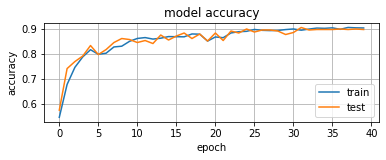

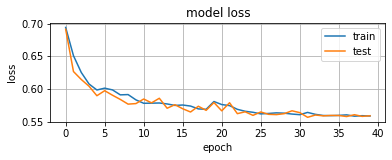

In [ ]:
base_model = keras.applications.ResNet152V2(                                    # TRANSFER LEARNING FROM RESNET 152 LAYERS
    weights=None,                                                               # LOAD PRETRAINED WEIGHTS OF IMAGENET
    input_shape=(256, 256, 3),                                                  # INPUT SHAPE
    include_top=False)                                                          # DO NOT INCLUDE THE CLASSIFIER AT THE TOP
base_model.trainable = True                                                     # FREEZE BASE MODEL
inputs = keras.Input(shape=(256, 256, 3))                                       # SET INPUT
x = data_augmentation(inputs)                                                   # APPLY RANDOM DATA AUGMENTATION
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)                   # SCALING LAYER
x = base_model(x, training=True)                                                # INFERENCE MODE -> TRAINING FALSE -> NO UPDATE WEIGHTS
x = keras.layers.GlobalAveragePooling2D()(x)                                    # GLOBAL AVERAGE POOLING
x = keras.layers.Dense(1024, activation='relu') (x)                             # DENSE LAYER 1024 UNITS
x = keras.layers.Dropout(0.5) (x)                                               # DROPOUT LAYER
outputs = keras.layers.Dense(1,activation='sigmoid')(x)                         # PREDICTIONS LAYER
ResNet152_model = keras.Model(inputs, outputs)                                  # MY RESNET MODEL
ResNet152_model.summary()                                                       # MODEL SUMMARY
ResNet152_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # ADAM OPTIMIZER
              loss=keras.losses.BinaryCrossentropy(from_logits=True),           # LOSS = BINARY CROSSENTROPY
              metrics=[keras.metrics.BinaryAccuracy(),
                       keras.metrics.FalsePositives(),
                       keras.metrics.FalseNegatives(),
                       keras.metrics.TruePositives(),
                       keras.metrics.TrueNegatives(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),]) 

es = tf.keras.callbacks.EarlyStopping(                                          # EARLY STOPPING
    monitor="val_loss",                                                         # QUALTITY MONITORED
    patience=15,                                                                # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE
    mode="auto")                                                                # MONITORING MODE
rl = tf.keras.callbacks.ReduceLROnPlateau(                                      # REDUCE LEARNING RATE ON PLATEAU
    monitor="val_loss",                                                         # QUANTITY MONITORED
    factor=0.5,                                                                 # FACTOR BY WHICH 
    patience=5,                                                                 # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE MODE
    mode="auto")                                                                # MONITORING MODE
ResNet152_history = ResNet152_model.fit(augmented_training_data,                # FIT THE MODEL
                                        epochs=40, callbacks=[es,rl],    
                                        validation_data=validation_data)    
plot_training_parameter(ResNet152_history)  

## Evaluation

In [ ]:
print("Evaluate on test data")
results = ResNet152_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

## Transfer Learning 

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

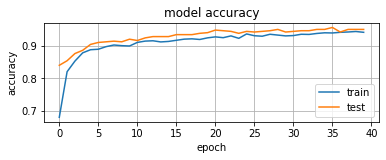

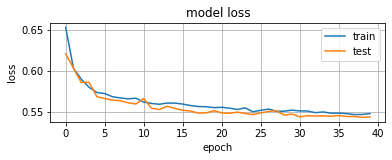

In [ ]:
base_model = keras.applications.ResNet152V2(                                    # TRANSFER LEARNING FROM RESNET 152 LAYERS
    weights='imagenet',                                                         # LOAD PRETRAINED WEIGHTS OF IMAGENET
    input_shape=(256, 256, 3),                                                  # INPUT SHAPE
    include_top=False)                                                          # DO NOT INCLUDE THE CLASSIFIER AT THE TOP
base_model.trainable = False                                                    # FREEZE BASE MODEL
inputs = keras.Input(shape=(256, 256, 3))                                       # SET INPUT
x = data_augmentation(inputs)                                                   # APPLY RANDOM DATA AUGMENTATION
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)                   # SCALING LAYER
x = base_model(x, training=False)                                               # INFERENCE MODE -> TRAINING FALSE -> NO UPDATE WEIGHTS
x = keras.layers.GlobalAveragePooling2D()(x)                                    # GLOBAL AVERAGE POOLING
x = keras.layers.Dense(1024, activation='relu') (x)                             # DENSE LAYER 1024 UNITS
x = keras.layers.Dropout(0.5) (x)                                               # DROPOUT LAYER
outputs = keras.layers.Dense(1,activation='sigmoid')(x)                         # PREDICTIONS LAYER
ResNet152_model = keras.Model(inputs, outputs)                                  # MY RESNET MODEL
ResNet152_model.summary()                                                       # MODEL SUMMARY
ResNet152_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # ADAM OPTIMIZER
              loss=keras.losses.BinaryCrossentropy(from_logits=True),           # LOSS = BINARY CROSSENTROPY
              metrics=[keras.metrics.BinaryAccuracy(),
                       keras.metrics.FalsePositives(),
                       keras.metrics.FalseNegatives(),
                       keras.metrics.TruePositives(),
                       keras.metrics.TrueNegatives(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),]) 
es = tf.keras.callbacks.EarlyStopping(                                          # EARLY STOPPING
    monitor="val_loss",                                                         # QUALTITY MONITORED
    patience=20,                                                                # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE
    mode="auto")                                                                # MONITORING MODE
rl = tf.keras.callbacks.ReduceLROnPlateau(                                      # REDUCE LEARNING RATE ON PLATEAU
    monitor="val_loss",                                                         # QUANTITY MONITORED
    factor=0.5,                                                                 # FACTOR BY WHICH 
    patience=8,                                                                 # NUMBER OF EPOCHS TO PATIENT
    verbose=1,                                                                  # VERBOSE MODE
    mode="auto")                                                                # MONITORING MODE
ResNet152TL_history = ResNet152_model.fit(augmented_training_data,              # FIT THE MODEL
                                        epochs=40, callbacks=[es,rl],    
                                        validation_data=validation_data)    
plot_training_parameter(ResNet152TL_history)  

## Evaluation

In [ ]:
print("Evaluate on test data")
results = ResNet152_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])

## Fine Tuning

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
resnet152v2 (Functional)     (None, 8, 8, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

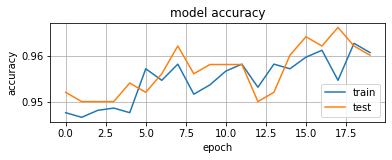

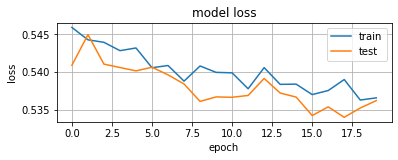

In [ ]:
base_model.trainable = True                                                     # UNFREEZE BASE MODEL
ResNet152_model.summary()                                                       # MODEL SUMMARY
ResNet152_model.compile(                                                        # COMPILE THE MODEL
    optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate                 # ADAM OPTIMIZER
    loss=keras.losses.BinaryCrossentropy(from_logits=True),                     # LOSS = BINARY CROSSENTROPY
    metrics=[keras.metrics.BinaryAccuracy(),
             keras.metrics.FalsePositives(),
             keras.metrics.FalseNegatives(),
             keras.metrics.TruePositives(),
             keras.metrics.TrueNegatives(),
             keras.metrics.Precision(),
             keras.metrics.Recall(),]) 
epochs = 20                                                                     # NUMBER OF EPOCHS
ResNet152FT_history = ResNet152_model.fit(augmented_training_data,              # FIT THE MODEL
                                        epochs=epochs, callbacks=[es,rl],    
                                        validation_data=validation_data)    
plot_training_parameter(ResNet152FT_history)  

## Evaluation

In [ ]:
print("Evaluate on test data")
results = ResNet152_model.evaluate(test_data, batch_size=128)
print('Loss:           ',results[0] ,'\nAccuracy:       ',results[1])
print('False Positive: ',results[2] ,'\nFalse Negative: ',results[3])
print('True Positive:  ',results[4] ,'\nTrue Negative:  ',results[5])
print('Precision    :  ',results[6] ,'\nRecall:         ',results[7])